Побудуй предикт річного LTV користувачів на основі тижневих когорт, користуючись
будь-яким зручним для тебе інструментом.

Завдання:

1) Розрахуй фактичний LTV користувачів та побудуй предикт на рік на основі тижневих когорт на прикріпленому семплі даних. Побудуй візуалізацію кривих предиктового та фактичного LTV.

2) Опиши обраний підхід та оціни якість побудованої моделі, запропонуй варіанти, як можна покращити точність предикту.

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ТЗ /ТЗ KissMyApps/KMA TestTask Product Analyst - Task2.csv', parse_dates=['event_timestamp','first_purchase_time','cohort_week'])

In [2]:
df.head(5)

,user_id,event_timestamp,first_purchase_time,cohort_week,lifetime_weeks,product_id
0,6f8592c0-fb4c-47dc-9344-424eb5d88a4b,2023-10-13 09:54:02,2023-10-13 09:54:02,2023-10-08,0,weekly.2.49
1,95287b91-85af-4174-9986-aeafb3853bb6,2023-10-14 04:45:14,2023-03-25 04:44:40,2023-03-19,29,weekly.2.49
2,95287b91-85af-4174-9986-aeafb3853bb6,2023-03-25 04:44:40,2023-03-25 04:44:40,2023-03-19,0,weekly.2.49
3,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-01 04:44:16,2023-03-25 04:44:40,2023-03-19,1,weekly.2.49
4,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-08 04:45:55,2023-03-25 04:44:40,2023-03-19,2,weekly.2.49


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6086 entries, 0 to 6085
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              6086 non-null   object        
 1   event_timestamp      6086 non-null   datetime64[ns]
 2   first_purchase_time  6086 non-null   datetime64[ns]
 3   cohort_week          6086 non-null   datetime64[ns]
 4   lifetime_weeks       6086 non-null   int64         
 5   product_id           6086 non-null   object        
dtypes: datetime64[ns](3), int64(1), object(2)
memory usage: 285.4+ KB


In [4]:
#перевірю значення lifetime_weeks
df['lifetime_weeks'].min()

0

In [5]:
#перевіряю розмір когорт
cohort_sizes = df.groupby('cohort_week')['user_id'].nunique().reset_index(name='users')
cohort_sizes.sort_values('users', ascending=True)

,cohort_week,users
31,2023-10-08,1
23,2023-08-06,1
19,2023-07-09,2
22,2023-07-30,2
28,2023-09-10,2
27,2023-09-03,2
20,2023-07-16,3
29,2023-09-17,3
30,2023-09-24,3
21,2023-07-23,4


In [6]:
# чищу когорти, щоб уникнути шум моделі потім
valid_cohorts = cohort_sizes[cohort_sizes['users'] >= 30]['cohort_week']
df = df[df['cohort_week'].isin(valid_cohorts)]

In [7]:
# додам колонку по ревеню
df['revenue'] = 2.49

In [8]:
# визначу кількість користувачів у кожній когорті
cohort_users = df.groupby('cohort_week')['user_id'].nunique().reset_index()
cohort_users.columns = ['cohort_week', 'n_users']
display(cohort_users)

,cohort_week,n_users
0,2023-03-05,88
1,2023-03-12,69
2,2023-03-19,84
3,2023-03-26,50
4,2023-04-02,36
5,2023-04-09,43
6,2023-04-16,56
7,2023-04-23,67
8,2023-04-30,68
9,2023-05-07,66


In [9]:
# порахую total revenue на кожному тижні
revenue_by_week = df.groupby(['cohort_week', 'lifetime_weeks'])['revenue'].sum().reset_index()
display(revenue_by_week)

,cohort_week,lifetime_weeks,revenue
0,2023-03-05,0,224.10
1,2023-03-05,1,149.40
2,2023-03-05,2,112.05
3,2023-03-05,3,94.62
4,2023-03-05,4,87.15
...,...,...,...
359,2023-06-04,15,27.39
360,2023-06-04,16,24.90
361,2023-06-04,17,29.88
362,2023-06-04,18,24.90


In [10]:
# ltv
ltv = revenue_by_week.merge(cohort_users, on='cohort_week')
ltv['ltv'] = ltv['revenue'] / ltv['n_users']
display(ltv)

,cohort_week,lifetime_weeks,revenue,n_users,ltv
0,2023-03-05,0,224.10,88,2.546591
1,2023-03-05,1,149.40,88,1.697727
2,2023-03-05,2,112.05,88,1.273295
3,2023-03-05,3,94.62,88,1.075227
4,2023-03-05,4,87.15,88,0.990341
...,...,...,...,...,...
359,2023-06-04,15,27.39,40,0.684750
360,2023-06-04,16,24.90,40,0.622500
361,2023-06-04,17,29.88,40,0.747000
362,2023-06-04,18,24.90,40,0.622500


In [11]:
# кумулятивний LTV
ltv = ltv.sort_values(['cohort_week', 'lifetime_weeks'])
ltv['cumulative_ltv'] = ltv.groupby('cohort_week')['ltv'].cumsum()
display(ltv)

,cohort_week,lifetime_weeks,revenue,n_users,ltv,cumulative_ltv
0,2023-03-05,0,224.10,88,2.546591,2.546591
1,2023-03-05,1,149.40,88,1.697727,4.244318
2,2023-03-05,2,112.05,88,1.273295,5.517614
3,2023-03-05,3,94.62,88,1.075227,6.592841
4,2023-03-05,4,87.15,88,0.990341,7.583182
...,...,...,...,...,...,...
359,2023-06-04,15,27.39,40,0.684750,17.990250
360,2023-06-04,16,24.90,40,0.622500,18.612750
361,2023-06-04,17,29.88,40,0.747000,19.359750
362,2023-06-04,18,24.90,40,0.622500,19.982250


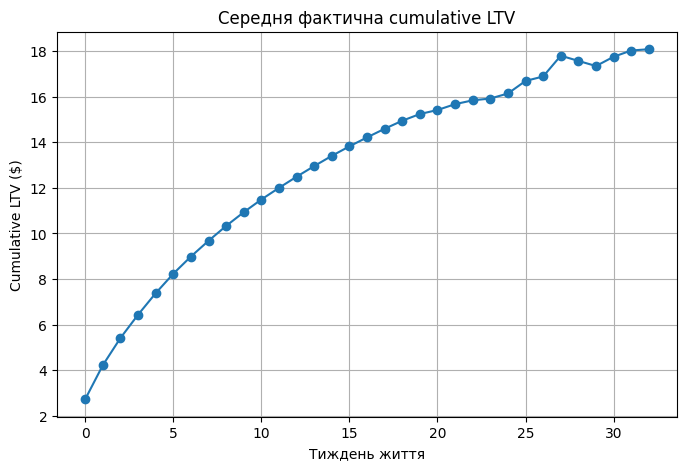

In [12]:
avg_ltv = ltv.groupby('lifetime_weeks')['cumulative_ltv'].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(avg_ltv['lifetime_weeks'], avg_ltv['cumulative_ltv'], marker='o')
plt.title('Середня фактична cumulative LTV')
plt.xlabel('Тиждень життя')
plt.ylabel('Cumulative LTV ($)')
plt.grid(True)
plt.show();

Перейдемо до прогнозу LTV

In [13]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [19]:
X = avg_ltv['lifetime_weeks']
Y = avg_ltv['cumulative_ltv']

# Експоненційна модель
def exp_model(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

# Логарифмічна модель
def log_model(x, a, b, c):
    return a * np.log(b * x + 1) + c

exp_params, _ = curve_fit(exp_model, X, Y, maxfev=10000, bounds=([0, 0, 0], [100, 1, 10]))

log_params, _ = curve_fit(log_model, X, Y, maxfev=10000, bounds=([0, 0, 0], [100, 1, 10]))

# Побудова прогнозної осі по тижнях
X_pred = np.arange(0, 53)

# Прогнозоване значення за експоненційною моделлю
exp_pred = exp_model(X_pred, *exp_params)

# Прогнозоване значення за логарифмічною моделлю
log_pred = log_model(X_pred, *log_params)

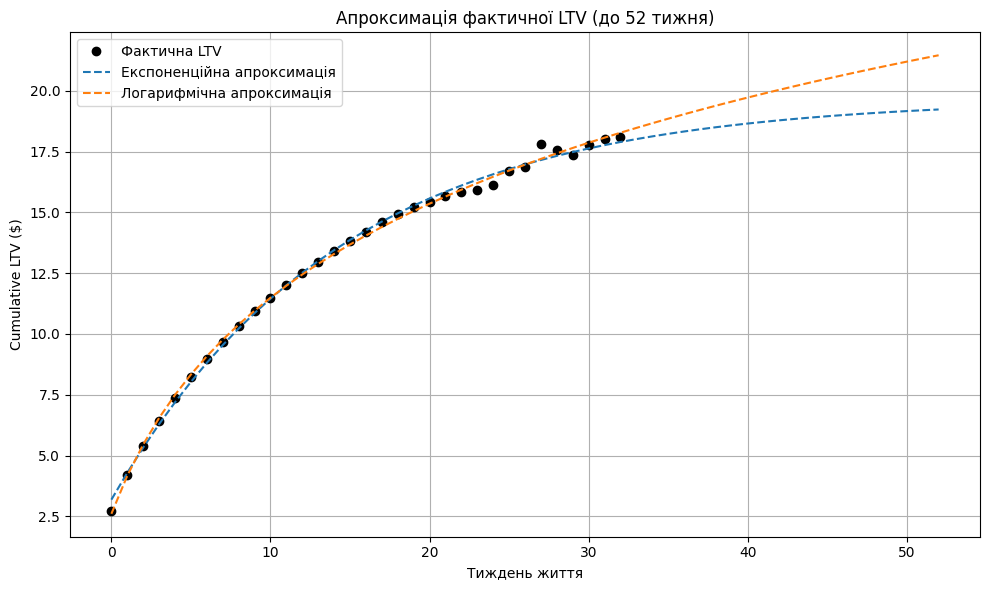

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(X, Y, 'o', label='Фактична LTV', color='black')
plt.plot(X_pred, exp_pred, '--', label='Експоненційна апроксимація')
plt.plot(X_pred, log_pred, '--', label='Логарифмічна апроксимація')
plt.title('Апроксимація фактичної LTV (до 52 тижня)')
plt.xlabel('Тиждень життя')
plt.ylabel('Cumulative LTV ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

In [21]:
ltv_52_exp = exp_model(52, *exp_params)
ltv_52_log = log_model(52, *log_params)

print(f"LTV на 52 тижні (експоненційна): {ltv_52_exp:.2f}")
print(f"LTV на 52 тижні (логарифмічна): {ltv_52_log:.2f}")

LTV на 52 тижні (експоненційна): 19.23
LTV на 52 тижні (логарифмічна): 21.46


З графіку бачимо, що затестувавши дві моделі — логарифмічну та експоненційну, можна прийняти висновок:

На основі форми фактичної кривої та графіка апроксимацій нам більше підходить - експоненційна модель.

Вона більш реалістична та консервативна для прогнозу.

**Підсумок дій:**

Для прогнозу річного LTV було обрано експоненційну модель, яка апроксимує середню cumulative LTV на основі фактичних даних за тижнями життя користувачів.

* Кожен користувач вносив фіксований дохід $2.49 за тиждень

* Фактична LTV була побудована по тижневих когортах

* Побудовано усереднену кумулятивну криву LTV

* Апроксимовано двома функціями: експоненційною та логарифмічною

На основі графіка та форми кривої обрано експоненційну модель як основну.

**Щодо моделі:**

* Експоненційна крива дуже близько проходить до фактичних точок до ~30 тижня.

* Модель реалістично загинається, що відповідає очікуваній поведінці платної підписки.

* Прогнозоване значення LTV на 52 тижні = $19.23.

Логарифмічна  модель (~$21.46) переоцінює довгостроковий LTV, тому відхилена.

На мою думку, саме експоненційна крива є консервативною та більш реалістичною. Адже життєвий цикл корситувача також може бути хитким.

**Що зробити, щоб покращити точність предикту:**

1) Збільшиити період спостереження.

Більше даних - більш точний прогноз.

2) Додатково сегментувати користувачів.

Наприклад, по типу підписок, джерелах трафіку чи країнах.

3) Додати аналіз ретеншену.

4) Використання sBG/BdW моделей.

**Також хочу спробувати інший підхід.**

На основі статті DOU - https://dou.ua/forums/topic/51693/, яка описує підхід до оцінки LTV через криву ретеншну.

Побудуємо альтернативний підхід до побудови LTV.

In [22]:
retention = df.groupby('lifetime_weeks')['user_id'].nunique()
retention = retention / retention.loc[0]

In [23]:
revenue = df.groupby('lifetime_weeks')['revenue'].sum()
users = df.groupby('lifetime_weeks')['user_id'].nunique()
arpu = revenue / users

In [24]:
ltv_from_retention = (retention * arpu).cumsum()

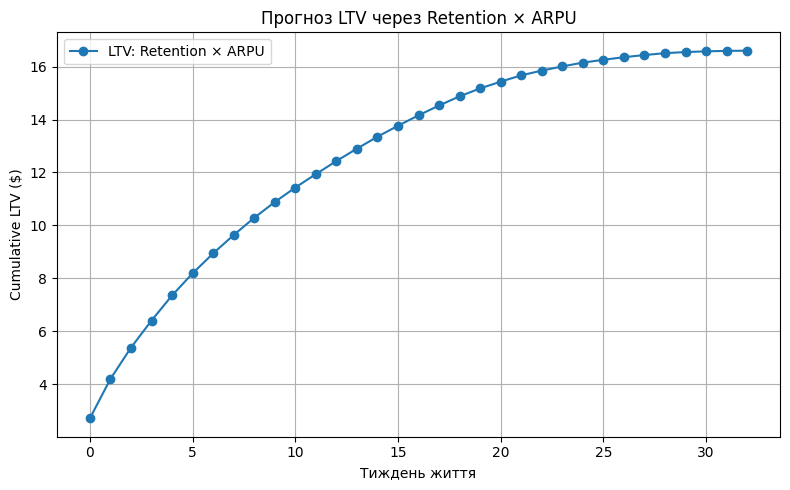

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(ltv_from_retention.index, ltv_from_retention.values, marker='o', label='LTV: Retention × ARPU')

plt.title('Прогноз LTV через Retention × ARPU')
plt.xlabel('Тиждень життя')
plt.ylabel('Cumulative LTV ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show();

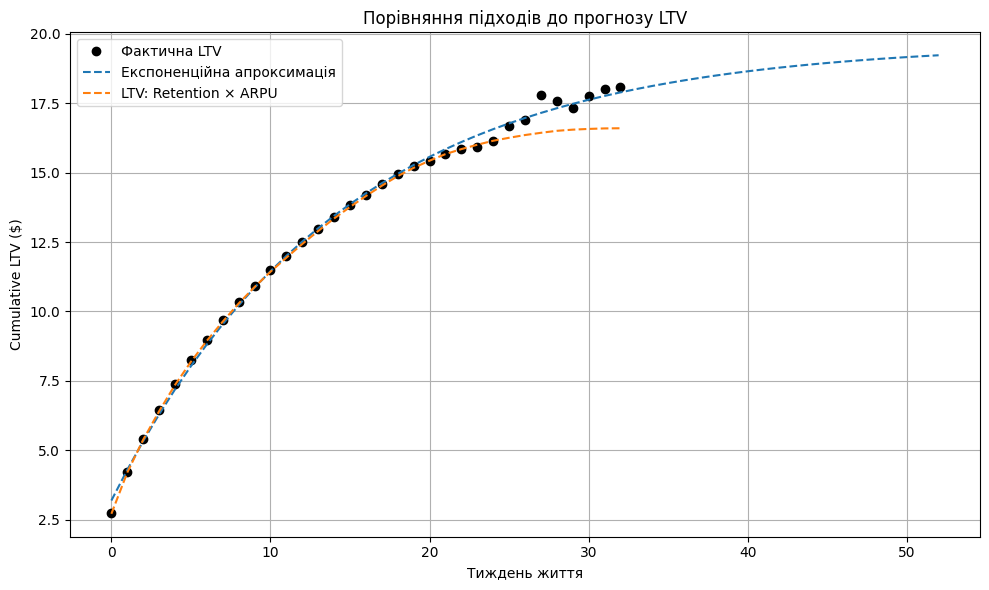

In [26]:
plt.figure(figsize=(10, 6))

# Фактична крива
plt.plot(avg_ltv['lifetime_weeks'], avg_ltv['cumulative_ltv'], 'o', label='Фактична LTV', color='black')

# Експоненційна
plt.plot(X_pred, exp_pred, '--', label='Експоненційна апроксимація')

# Retention × ARPU
plt.plot(ltv_from_retention.index, ltv_from_retention.values, '--', label='LTV: Retention × ARPU')

plt.title('Порівняння підходів до прогнозу LTV')
plt.xlabel('Тиждень життя')
plt.ylabel('Cumulative LTV ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show();

In [27]:
from scipy.optimize import curve_fit
import numpy as np

# Дані
weeks_ret = retention.index.to_numpy()
values_ret = retention.values

# Побудуємо експоненційну модель для Retention
def retention_model(x, a, b):
    return a * np.exp(-b * x)

ret_params, _ = curve_fit(retention_model, weeks_ret, values_ret, maxfev=10000)
ret_pred = retention_model(np.arange(0, 53), *ret_params)

In [28]:
weeks_arpu = arpu.index.to_numpy()
values_arpu = arpu.values

def arpu_model(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

arpu_params, _ = curve_fit(arpu_model, weeks_arpu, values_arpu, maxfev=10000)
arpu_pred = arpu_model(np.arange(0, 53), *arpu_params)

In [29]:
ltv_pred_ret_arpu = (ret_pred * arpu_pred).cumsum()

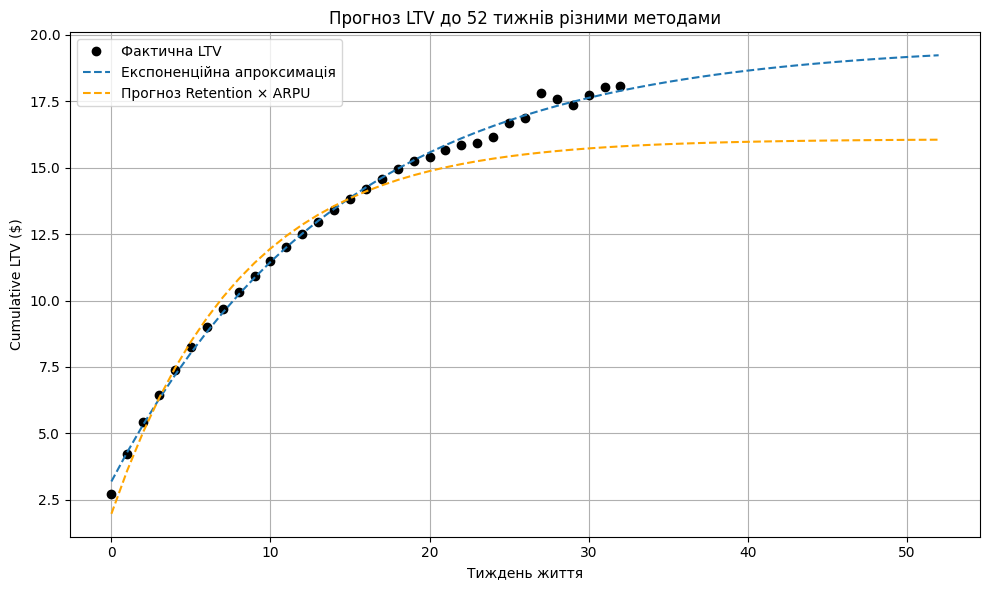

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(avg_ltv['lifetime_weeks'], avg_ltv['cumulative_ltv'], 'o', label='Фактична LTV', color='black')
plt.plot(np.arange(0, 53), exp_pred, '--', label='Експоненційна апроксимація')
plt.plot(np.arange(0, 53), ltv_pred_ret_arpu, '--', label='Прогноз Retention × ARPU', color='orange')

plt.title('Прогноз LTV до 52 тижнів різними методами')
plt.xlabel('Тиждень життя')
plt.ylabel('Cumulative LTV ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

In [31]:
print(f"LTV на 52 тижні (прогноз Retention × ARPU): ${ltv_pred_ret_arpu[52]:.2f}")

LTV на 52 тижні (прогноз Retention × ARPU): $16.05


**Висновки до цього підходу:**

* Прогнозований LTV на 52 тижні: $16.05

* Ця крива реалістично насичується, стабілізується після ~30 тижня

* Зображує ще більш консервативний прогноз.

Цей прогноз було побудовано через Retention × ARPU — дозволяє врахувати внесок поведінки (Retention) та дохідності (ARPU).

- Визначила ARPU та Retention

- Побудовала їх апроксимації

- Спрогнозувала кумулятивну LTV-криву до 52 тижня

**Щодо якості моделі:**

* Модель дуже добре повторює форму фактичної кривої до ~23 тижня.

* Після цього стабілізується, що є реалістичним для продукту з підписною моделлю.

* Прогнозований LTV - 16.05$ дещо нижчий за експоненційний - 19.23,
що свідчить про консервативність та обережність оцінки.

**Що зробити, щоб покрщити точність прогнозу:**

1) Також більше даних зібрати.

2) Сегментація Retention та ARPU — за країнами або типом користувача.

3) Додати модель (наприклад sBG) — як додатковий шар перевірки.

**Порівняння та висновки по підходам аналізу:**

Обидва підходи дали схожий тренд - це свідчить про надійність результату.

Експоненційна модель — краща для “загального прогнозу”.

Retention × ARPU — зручна для бізнес-інтерпретацій.

Розбіжність у прогнозах (~$3.2) відображає різний ступінь обережності моделей — експоненційна дає більш оптимістичну оцінку, тоді як Retention × ARPU занижує результат, мінімізуючи ризик переоцінки.